# Projeto 2 - Supervised Learning

## Random Forest Classifier & SVM/SVC

*Ian Loron de Almeida - 198933*

*Dorival Junior da Silva - *  

**Documento escrito por Ian Loron de Almeida**

Nesta parte do projeto, trabalharemos com os modelos de aprendizado supervisionado 'Random Forest Classifier' e 'SVM - Support Vector Machine'. O projeto está estruturado considerando as seguintes etapas:

1- importação de todas as bibliotecas necessárias para o desenvolvimento do código;

2- importação os dados do bancode dados 'load_digits()';

3- tratamento de dados para visualização, através do método t-SNE;

4- Para cada modelo, será procurado os melhores hiperparâmetros:

4.1- Procura-se hiperparâmetros em testes com seleção de hiperparâmetros pseudo-randômicos;

4.2- De acordo com os reusltados, será procurado por valores que tragam melhores resultados, em uma busca mais refinada e restrita dos intervalos dos hiperparâmetros;

5- Os modelos receberão os dados de teste  para prever;

6- comentários e conclusões;

Importando bibliotecas:

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
# feature scaling - necessary due to SVM
from sklearn.preprocessing import StandardScaler
# split data
from sklearn.model_selection import train_test_split
# to cv split
from sklearn.model_selection import ShuffleSplit
# matplot libs
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 
# to classification report
from sklearn import metrics
# to t-SNE reduction
from sklearn.manifold import TSNE
# to calculate cv - to the learning curve
from sklearn.model_selection import learning_curve
# to get parameters from classifier methods, in order to find best hyperparameters
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Carregando dados dos dígitos, os separando entre dados para treino e teste (X) dos valores corretos correspondentes ao que cada tupla de dados em X significa. 

Além disso, faz-se a distribuicão estocática (aplicacao do t-SNE) para um plano bidimensional. Com esses dados, separa-se os dados de treino e de teste na razão 90/10.

In [2]:
digits = load_digits()
X = digits.data
y = digits.target
X_reduced = TSNE(n_components=2).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y,test_size=0.10, random_state=10)

Aqui, define-se como os dados serao divididos durante o cross-validation. Para melhor distribuicao dos dados, optou-se pela divisao aleatória dos dados, na razao 75/25 entr dados de treinamento e dados de validacao.

In [3]:
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=10)

funcao para imprimir mapa de distribuicao estocática após aplicacao do tratamento de dados t-SNE.

In [5]:
# example of t-SNE projection 2-dimensional reduction 
# based on example from https://umap-learn.readthedocs.io/en/latest/basic_usage.html

def print_2d_data(embedding, target):
    plt.scatter(embedding[:, 0], embedding[:, 1], c=target, cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title('t-SNE projection of the Digits in training dataset', fontsize=24);

Função para imprimir diferentes *scores*, obtidos em um cross-validation.

In [4]:
def print_val_scores(model, X_train, y_train, cv):
    _,__,f1_w,f1_m,r,p=cross_validate(model, X_train, y_train, cv=cv,
                       scoring=['f1_weighted','f1_macro','recall_weighted','precision_weighted']).items()
    mean_f1_w = f1_w[1].mean(); sd_f1_w = f1_w[1].std()
    mean_f1_m = f1_m[1].mean(); sd_f1_m = f1_m[1].std()
    mean_r = r[1].mean(); sd_r = r[1].std()
    mean_p = p[1].mean(); sd_p = p[1].std()
    
    print("Classification report for classifier {}:\nparameters:\n".format(model) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_w,mean_f1_w,sd_f1_w) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_m,mean_f1_m,sd_f1_m) +
          "{}\nmean: {}, std deviation: {}\n\n".format(r,mean_r,sd_r) +
          "{}\nmean: {}, std deviation: {}\n\n".format(p,mean_p,sd_p))

Imprime-se os *scores* que uma *Random Forest* padrao do sklearn performa. Note que os valores já sao relativamente altos. Ao longo do projeto, será buscado afinar o acerto do modelo.

In [18]:
clf_rf=RandomForestClassifier()
print_val_scores(clf_rf, X_train,y_train,ss)

Classification report for classifier RandomForestClassifier():
parameters:
('test_f1_weighted', array([0.97512345, 0.97783058, 0.9827494 , 0.99011606, 0.98272966]))
mean: 0.9817098308223884, std deviation: 0.005122782208648969

('test_f1_macro', array([0.97651864, 0.97785368, 0.98232091, 0.99012794, 0.98278093]))
mean: 0.9819204193684948, std deviation: 0.004774553579677992

('test_recall_weighted', array([0.97530864, 0.97777778, 0.98271605, 0.99012346, 0.98271605]))
mean: 0.9817283950617284, std deviation: 0.005084261798018286

('test_precision_weighted', array([0.97579196, 0.97821969, 0.98330161, 0.99022438, 0.98285907]))
mean: 0.982079340279095, std deviation: 0.005084261798018286




Função para imprimir métricas, quando posteriormente testarmos o conjunto de dados de testes.

In [61]:
def print_metrics(clf, X, y, prediction):
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y, prediction)}\n")
    disp = metrics.plot_confusion_matrix(clf, X, y)
    disp.figure_.suptitle("Confusion Matrix")

Imprime distribuição de dados de teste após aplicação do t-SNE.

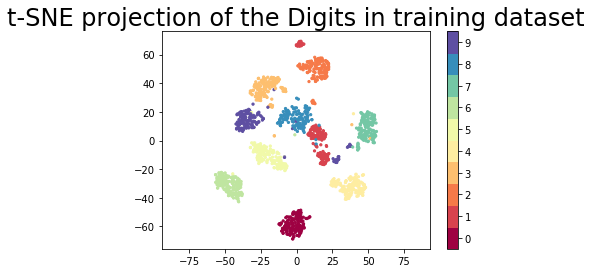

In [6]:
# print data distribution after t-SNE reduction
print_2d_data(X_train, y_train)

### Busca por melhores hiperparâmetros para a Random Forest Classifier:

Criacao do 1° grid de valores da Random Forest, para procurar pelos melhores hiperparâmetros.

In [29]:
# Documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


Aplicou-se os valores do grid para a primeira busca dos hiperparâmetros. Inicialmente, aplicamos uma busca randomizada. Posteriormente, refinaremos a procura.

In [30]:
# Use the random grid to search for best hyperparameters

# 1. create the base models 
clf_rf = RandomForestClassifier()

# 2. Random search of parameters. Uses our shuffle selection cross validation, 
#    and search across 100 different (shuffle) combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid_rf, 
                               n_iter = 100, cv = ss, random_state=10)

# 3. Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10, test_size=0.25, train_size=None),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 28, 52, 76, 100, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=10)

Melhores parametros encontrados:

In [31]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': True}

In [36]:
# Through Random Forest Classifier with the best parameters, train and predict data.
best_random_rf=rf_random.best_estimator_ 
print_val_scores(best_random_rf, X_train, y_train, ss)

Classification report for classifier RandomForestClassifier(max_depth=100, max_features='log2', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=300):
parameters:
('test_f1_weighted', array([0.98012565, 0.97774023, 0.98519436, 0.99011606, 0.98515179]))
mean: 0.9836656178135537, std deviation: 0.00433117913962484

('test_f1_macro', array([0.98135346, 0.9776045 , 0.98512184, 0.99012794, 0.98550266]))
mean: 0.9839420794134466, std deviation: 0.004218008292634517

('test_recall_weighted', array([0.98024691, 0.97777778, 0.98518519, 0.99012346, 0.98518519]))
mean: 0.9837037037037037, std deviation: 0.004305085376336473

('test_precision_weighted', array([0.98049979, 0.97804196, 0.98552083, 0.99022438, 0.98530045]))
mean: 0.9839174816034773, std deviation: 0.004253530402065733




Agora que temos melhor noção de quais são parâmetros desejáveis para obter melhores resultados, podemos fazer uma busca pelos melhores hiperparâmetros de maneira mais refinada. Ao invés de usarmos o RandomizedSearchCV, usaremos o GridSearchCV, o qual fará a busca dos melhores hiperparâmetros ao comparar todos os parâmetros que passarmos.

Note que os parâmetros criados no grid estao em um intervalo menor, e mais próximos dos melhores hiperparametros encontrados com o RandomizedSearchCV.

In [33]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120], # [23, 28, 33],
    'max_features': ['log2'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [3,4,5],
    'n_estimators': [250, 300, 350] # [550, 600, 700]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_rf, param_grid = param_grid, cv = ss)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'bootstrap': True, 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 250}


**Obs:** Somente quando aplicamos "fit" é que o RandomizedSearchCV (e posteriormente, o GridSearchCV) procura os melhores parâmetros, **de acordo com a especificação de cross-validation passada**. Assim, o treinamento não é feito em todos os dados de testes, mas sim de acordo com o cros-validation. Podemos criar um modelo com estes parâmetros chamando "best_estimator_":  

In [37]:
best_grid_rf = grid_search.best_estimator_
print_val_scores(best_grid_rf, X_train, y_train, ss)

Classification report for classifier RandomForestClassifier(max_depth=80, max_features='log2', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=250):
parameters:
('test_f1_weighted', array([0.9801754 , 0.9777665 , 0.98519436, 0.99011606, 0.9876292 ]))
mean: 0.9841763054743666, std deviation: 0.0045898232909632

('test_f1_macro', array([0.9813186 , 0.97769055, 0.98512184, 0.99012794, 0.98788656]))
mean: 0.9844290970185356, std deviation: 0.004471999248252748

('test_recall_weighted', array([0.98024691, 0.97777778, 0.98518519, 0.99012346, 0.98765432]))
mean: 0.9841975308641976, std deviation: 0.0045795646891336785

('test_precision_weighted', array([0.98061784, 0.97815335, 0.98552083, 0.99022438, 0.98772949]))
mean: 0.9844491788023664, std deviation: 0.004462698307897226




Os resultados obtidos foram muito próximos dos resultados que obtivemos anteriormente com o RandomizedSearchCV, o que era esperado, visto que já tinhamos resultados muito bons. 

Todos os métodos de validação foram muito semelhantes e com pouca variação. Para fins de comparação, falaremos do *f1 weighted*, pois consegue avaliar não só a relação entre *recall* e *precision* como também pondera os resultados de acordo com o desbalanceamento das *labels*, o que as demais maneiras de predição de f1 não fazem:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Escolheu-se o f1 pois neste problema, consideramos que ambos *precision* e *recall* tem a mesma importância.

Do método padrão do RandomForestClassifier para a primeira busca de hiperparâmetros, passamos da média de 0.981 para 0.983 


### Busca para os melhores hiperparâmetros para SVM:

Agora, faremos o mesmo processo, para o nosso segundo método, o *SVM*. Em especial, como, de acordo com as especificações do *SVM* o método *SVC* é mais adequado para nosso problema, alteraremos os hiperparâmetros apenas do *SVC - Support Vector Classification* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#.

O tamanho do dataset é pequeno o suficiente para utilizá-lo com rapidez.Queríamos um método de classificação não linear para nosso experimento, a fim de comparar com a *Random Forest Clasification*.

Hiperparâmetros existentes no SVM:

In [7]:
clf_svm = make_pipeline(StandardScaler(), SVC())
print(pprint(clf_svm.get_params() ))

{'memory': None,
 'standardscaler': StandardScaler(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'verbose': False}
None


Note que a documentação da biblioteca recomenda que seja feito o dimensionamento dos dados *(feature scaling)*, uma vez que o SVM é sensiível ao dimensionamento: https://scikit-learn.org/stable/modules/svm.html#svm

Por facilidade, utilizou-se o StandardScaler para tal. 

Note que no modelo de *Random Forest Classification*, não precisamos redimensionar, uma vez que o modelo não é sensível a diferença de escala dos dados.

*Scores* encontrados a partir dos hiperparâmetros padräo do sklearn, para o *SVM*:

In [8]:
print_val_scores(clf_svm, X_train,y_train,ss)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())]):
parameters:
('test_f1_weighted', array([0.9467624 , 0.96271903, 0.967715  , 0.97747453, 0.96741863]))
mean: 0.9644179167997138, std deviation: 0.010049416218160176

('test_f1_macro', array([0.94611419, 0.96260639, 0.96712135, 0.97562198, 0.96855364]))
mean: 0.9640035090665136, std deviation: 0.009873126947841199

('test_recall_weighted', array([0.94814815, 0.96296296, 0.96790123, 0.97777778, 0.96790123]))
mean: 0.9649382716049383, std deviation: 0.009676996514698956

('test_precision_weighted', array([0.95456253, 0.96519706, 0.97046227, 0.97936284, 0.96906669]))
mean: 0.9677302769937832, std deviation: 0.008054478435889861




Em especial, trabalharemos com os parâmetros do *SVC*. Entre os hiperparâmetros, foram escolhidos aqueles que pudessem ser aplicados a todos os tipos de *kernel*, e que tivesem maior relação com a performance do *SVM*.

In [20]:
# Documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# Cost regulator parameter.
C = [float(x) for x in np.linspace(start = 0.1, stop = 100.0, num = 10).astype(float)]
# Weights associated with classes.
# According to t-SNE projection, we can give harder costs to classes well distributed (e.g. 0) and
# costs for smoothier results to classes badly distributed (e.g. 1) 
class_weight=['balanced', None,{0:1,1:1,2:10,3:15,4:1,5:3,6:1,7:20,8:200,9:150},
                               {0:10,1:20,2:10,3:15,4:10,5:13,6:10,7:20,8:99,9:75}]
# Specifies the kernel type to be used in the algorithm.
kernel = ['linear', 'poly', 'rbf','sigmoid']
# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = ['scale', 'auto']
# Whether to return a one-vs-rest or one-vs-one. 
decision_function_shape = ['ovo','ovr']
# Whether to use the shrinking heuristic.
shrinking = [True, False]

# Create the random grid
random_grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight':class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking}
pprint(random_grid_svm)

{'svc__C': [0.1,
            11.200000000000001,
            22.300000000000004,
            33.400000000000006,
            44.50000000000001,
            55.60000000000001,
            66.7,
            77.80000000000001,
            88.9,
            100.0],
 'svc__class_weight': ['balanced',
                       None,
                       {0: 1,
                        1: 1,
                        2: 10,
                        3: 15,
                        4: 1,
                        5: 3,
                        6: 1,
                        7: 20,
                        8: 200,
                        9: 150},
                       {0: 10,
                        1: 20,
                        2: 10,
                        3: 15,
                        4: 10,
                        5: 13,
                        6: 10,
                        7: 20,
                        8: 99,
                        9: 75}],
 'svc__decision_function_shape': ['ovo', 'ovr'],
 'svc

Escolha dos melhores hiperparâmetros dentre 100 combinações distintas e aleatórias dos hiperparâmetros criados na grid:

In [39]:
# 1. create the base models 
clf_svm = make_pipeline(StandardScaler(), SVC())

# 2. Random search of parameters. Uses our shuffle selection cross validation, 
# and search across 100 different (shuffle) combinations, and use all available cores
svm_random = RandomizedSearchCV(estimator = clf_svm, param_distributions = random_grid_svm, 
                                n_iter = 100, cv = ss, random_state=20)

# 3. Fit the random search model
svm_random.fit(X_train, y_train)
svm_random.best_params_

{'svc__shrinking': True,
 'svc__kernel': 'rbf',
 'svc__gamma': 'auto',
 'svc__decision_function_shape': 'ovo',
 'svc__class_weight': 'balanced',
 'svc__C': 100.0}

In [38]:
# Through Random Forest Classifier with the best parameters, train and predict data.
best_random_svm=svm_random.best_estimator_ 
print_val_scores(best_random_svm, X_train, y_train, ss)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, shrinking=False))]):
parameters:
('test_f1_weighted', array([0.98760085, 0.98515545, 0.98764242, 0.99259575, 0.9876292 ]))
mean: 0.9881247340238067, std deviation: 0.0024314300511359657

('test_f1_macro', array([0.98846579, 0.98504109, 0.98746055, 0.99267357, 0.98788656]))
mean: 0.9883055113439662, std deviation: 0.0024759469758963465

('test_recall_weighted', array([0.98765432, 0.98518519, 0.98765432, 0.99259259, 0.98765432]))
mean: 0.988148148148148, std deviation: 0.002419249128674752

('test_precision_weighted', array([0.98778041, 0.98529718, 0.98801643, 0.99265432, 0.98772949]))
mean: 0.9882955651791665, std deviation: 0.0023938597957357355




Os resultados foram muito bons. Ainda assim, procuraremos melhorar levemente o resultado. Porém, note que o custo está muito alto. Queremos descobrir se com outra combinação de valores de hiperparâmetros encontramos um custo menor, para que não haja overfit. 

Além disso, procuraremos por outros valores para *class_weight*, a fim de conseguir um modelo que se adeque melhor a peculiaridade de cada classe. Note que os pesos das classes estão de acordo com os valores encontrados no plot de distribuição dos valores após a aplicação do t-SNE. Quanto mais espalhado os parâmetros, e com maior interação com outras classes, maior será o peso; e vice-versa. 


In [41]:
# Cost regulator parameter.
C = [float(x) for x in np.linspace(start = 5.0, stop = 150.0, num = 15).astype(float)]

class_weight=['balanced', None,{0:1,1:1,2:10,3:15,4:1,5:3,6:1,7:20,8:200,9:150},
                               {0:10,1:10,2:100,3:150,4:10,5:30,6:10,7:200,8:2000,9:1500},
                               {0:0.1,1:0.1,2:1,3:1.5,4:0.1,5:0.3,6:0.1,7:2,8:20,9:15},
                               {0:100,1:200,2:100,3:150,4:10,5:130,6:100,7:200,8:990,9:750},
                               {0:10,1:20,2:10,3:15,4:10,5:13,6:10,7:20,8:99,9:75}]
# Specifies the kernel type to be used in the algorithm.
kernel = ['rbf']
# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma = ['scale', 'auto']
# Whether to return a one-vs-rest or one-vs-one. 
decision_function_shape = ['ovo']
# Whether to use the shrinking heuristic.
shrinking = [True, False]

# Create the random grid
param_grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight': class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking}

# Instantiate the grid search model
grid_search_svm = GridSearchCV(estimator = clf_svm, param_grid = param_grid_svm, cv = ss)
grid_search_svm.fit(X_train, y_train)
grid_search_svm.best_params_

{'svc__C': 25.714285714285715,
 'svc__class_weight': {0: 100,
  1: 200,
  2: 100,
  3: 150,
  4: 10,
  5: 130,
  6: 100,
  7: 200,
  8: 990,
  9: 750},
 'svc__decision_function_shape': 'ovo',
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__shrinking': True}

In [42]:
best_grid_svm = grid_search_svm.best_estimator_
print_val_scores(best_grid_svm, X_train, y_train, ss)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=25.714285714285715,
                     class_weight={0: 100, 1: 200, 2: 100, 3: 150, 4: 10,
                                   5: 130, 6: 100, 7: 200, 8: 990, 9: 750},
                     decision_function_shape='ovo'))]):
parameters:
('test_f1_weighted', array([0.98270186, 0.99012277, 0.98523727, 0.99259802, 0.990123  ]))
mean: 0.9881565859361219, std deviation: 0.0036258901211546155

('test_f1_macro', array([0.98293102, 0.99031386, 0.98458149, 0.99246354, 0.99027475]))
mean: 0.9881129316569828, std deviation: 0.0036815399746846613

('test_recall_weighted', array([0.98271605, 0.99012346, 0.98518519, 0.99259259, 0.99012346]))
mean: 0.9881481481481481, std deviation: 0.003628873693012118

('test_precision_weighted', array([0.98308871, 0.9902959 , 0.98574074, 0.9927193 , 0.9902535 ]))
mean: 0.9884196292409987, std deviation: 0.0034918710930871687




  Com os novos hiperparâmetros, encontramos hiperparâmetros que melhor se adequaram ao modelo. Ainda assim, na média dos novos testes de cross-validation, manteve-se a média dos valores dos *scores* com o RandomizedSearchCV- ainda assim resultados muito bons, e melhores que os *scores* encontrados com o SVM de hiperparâmetros padrão.

Por fim, utilizaremos esses hiperparâmetros para predizer os dados de teste, e descobrir se nosso modelo consegue satisfatóriamente encontrar as respostas desejadas, ou se está com overfit.

### Resultados dos modelos com os novos hiperparâmetros para a predição dos dados de teste:

**Para a Random Forest Classifier:**

Classification report for classifier RandomForestClassifier(max_depth=80, max_features='log2', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=250):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        21
           4       1.00      0.90      0.95        21
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        12
           7       0.86      1.00      0.92        18
           8       1.00      0.96      0.98        23
           9       1.00      0.95      0.98        22

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180




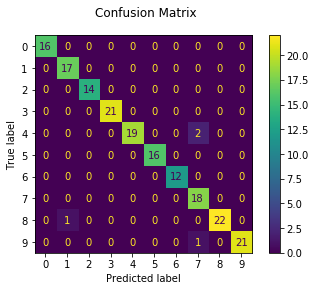

In [63]:
# fit and predict data - Random Forest
best_grid_rf.fit(X_train, y_train)
prediction_rf = best_grid_rf.predict(X_test)
print_metrics(best_grid_rf, X_test, y_test, prediction_rf)

**Para o Support Vector Machine:**

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=25.714285714285715,
                     class_weight={0: 100, 1: 200, 2: 100, 3: 150, 4: 10,
                                   5: 130, 6: 100, 7: 200, 8: 990, 9: 750},
                     decision_function_shape='ovo'))]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        21
           4       0.95      1.00      0.98        21
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        18
           8       1.00      0.96      0.98        23
           9       1.00      0.95      0.98        22

    accuracy                           0

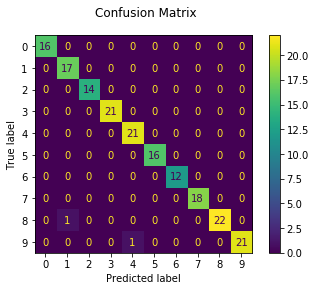

In [64]:
# fit and predict data to SVM
best_grid_svm.fit(X_train, y_train)
prediction_svm = best_grid_svm.predict(X_test)
print_metrics(best_grid_svm, X_test, y_test, prediction_svm)

Como podemos ver, os resultados foram bastante expressivos. Ambos os modelos conseguiram prever com muita precisão e exatidão os valores. Em especial, para a *Random Forest*, a precisão da classe "7" foi particularmente abaixo da média. Ainda assim, obteve alto recall. 

No caso da SVM, como escolhemos o custo de cada classe individualmente, os valores de precisão e de exatidão foram muito próximos, e muito altos. Os resultados foram surpreendentes.

### **Comentários Finais**

Ambos os modelos de classificação tiveram resultados muito significativos. 

Entre as vantagens do Random Forest Classification em relação do SVC, ficou evidente que não é necessário o dimensionamento dos dados. 

Entre as vantagens do SVC em relação ao Random Forest Classifier, destaca-se - para os hiperparâmetros utilizados - maior acurácia e menor desvio padrão entre os testes. Isto é, o modelo foi mais flexível para predizer novas amostras; e os resultados foram mais consistentes (com menor variação de erro) e acertivos. Além disso, notou-se que o modelo se comportou com velocidade relativamente maior, mesmo com aproximadamente a mesma quantidade hiperparâmetros sendo testados nos grids, em relação à Random Forest.